# Age and Gender Distortion Analysis

This notebook examines the **joint distortion of age and gender** in Large Language Models and in results of online search , following the methodology introduced in  
[*Age and gender distortion in online media and large language models*](https://www.nature.com/articles/s41586-025-09581-z).

The analysis follows these steps:

1) Using the data from `GPT2-large-dimensions.csv`, where each social category is mapped to numbers on the age and the sex dimension, we:
   - Compute the **Pearson correlation** between the age and sex dimensions (including confidence interval and significance statistics).
   - Test robustness by computing **all pairwise correlations** across alternative extraction methods and visualizing them as **heatmaps** (age and gender).
   - Fit an **OLS regression** between the normalized age and gender measures and reproduce the reported summary results.
   - Produce a **regression scatter plot** with highlighted representative categories and an **interactive version** .

2) Using the experiment results from `experiment_control.csv` and `experiment_treatment.csv`, we:
   - Construct the **image-search distortion measure** as (treatment subject’s estimated age) minus (control-group mean age for the same occupation), split by uploaded image gender.
   - Visualize the resulting **male vs female distortion distributions** and reproduce the key **t-test comparisons** reported in the paper (female vs male within treatment; female vs control; male vs control).
   - Investigate amplification via regression on the combined dataset: estimate a model with `age` as the dependent variable and predictors `condition * gender` (treatment coding, Male reference), plus fixed effects for `category` and `subj`, and report the regression results.
   - Fit a second regression with only `category` and `subj`, use it to generate **predictions and residuals**, and plot grouped predictions (by condition × gender) and residual distributions, explaining the observed patterns.
   - Run two **ANOVA** models (Sum encoding): (i) `condition * gender` only, and (ii) `condition * gender` plus `category` and `subj`, and interpret what changes when controlling for occupation and subject effects.


In [1]:
# Environment setup (run once)
# After running this cell, restart the kernel and run all cells

%pip install numpy pandas scipy pingouin statsmodels matplotlib seaborn altair requests


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import numpy as np
import pandas as pd
import requests

from scipy import stats
from scipy.stats import gaussian_kde
import pingouin as pg

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.ticker import FixedLocator, MultipleLocator
import seaborn as sns
import altair as alt
from IPython.display import display, HTML


## Section 0: Fetching the data

We first have to fetch the data uploaded by the researchers from Google Drive and store them in a csv.

In [3]:
def download_drive_file(file_id, output_file):
    if os.path.exists(output_file):
        print(f"[OK] File already exists: {output_file}")
        return

    print(f"[INFO] Downloading {output_file}...")

    session = requests.Session()
    url = "https://drive.google.com/uc?export=download"

    response = session.get(url, params={"id": file_id}, stream=True)
    response.raise_for_status()

    for key, value in response.cookies.items():
        if key.startswith("download_warning"):
            response = session.get(
                url,
                params={"id": file_id, "confirm": value},
                stream=True
            )
            break

    with open(output_file, "wb") as f:
        for chunk in response.iter_content(32768):
            if chunk:
                f.write(chunk)

    print(f"[DONE] Saved as {output_file}")

FILES = {
    "GPT2-large-dimensions.csv": "1-_PYdwqtdTRhZfTBMxCowRhFjFz9aJR_",# For examination of LM embeddings
    "experiment_control.csv": "10TKm_MYZdfIteWWKw4t33XZ1vUAVSJwM", # For amplification experiment
    "experiment_treatment.csv": "10WIozMmOFErIu0Fu_uiVq5RgpvkCFzwQ",# For amplification experiment
}

for filename, file_id in FILES.items():
    download_drive_file(file_id, filename)


[INFO] Downloading GPT2-large-dimensions.csv...
[DONE] Saved as GPT2-large-dimensions.csv
[INFO] Downloading experiment_control.csv...
[DONE] Saved as experiment_control.csv
[INFO] Downloading experiment_treatment.csv...
[DONE] Saved as experiment_treatment.csv


## Section 1: Age–Gender Associations in Language Model Embeddings

We use the `GPT2-large-dimensions.csv` dataset.

In [4]:
df = pd.read_csv("GPT2-large-dimensions.csv")

In [5]:
df.head(5)

,Social.Category,Source,gender.main,gender_norm.main,gender.ext,gender_norm.ext,gender.red,gender_norm.red,age.main,age_norm.main,age.ext,age_norm.ext,age.red,age_norm.red
0,abandoned infant,GPT2,-0.197087,0.540877,0.001662,0.527162,-0.108243,0.561858,-0.070237,0.357426,-0.004732,0.319985,-0.055446,0.419423
1,abandoned person,GPT2,-0.199134,0.535577,0.001236,0.523567,-0.110507,0.554830,-0.065570,0.382294,-0.001178,0.343708,-0.048989,0.477159
2,abiogenist,GPT2,-0.231156,0.452671,0.004317,0.549545,-0.151075,0.428889,-0.097012,0.214761,-0.026444,0.175097,-0.063784,0.344863
3,able-bodied seaman,GPT2,-0.162948,0.629264,0.001341,0.524456,-0.067956,0.686928,-0.042036,0.507690,0.016286,0.460250,-0.043687,0.524568
4,able seaman,GPT2,-0.181426,0.581424,0.002330,0.532793,-0.089043,0.621465,-0.055517,0.435856,0.006879,0.397472,-0.049394,0.473540


In [6]:
df.columns

Index(['Social.Category', 'Source', 'gender.main', 'gender_norm.main',
       'gender.ext', 'gender_norm.ext', 'gender.red', 'gender_norm.red',
       'age.main', 'age_norm.main', 'age.ext', 'age_norm.ext', 'age.red',
       'age_norm.red'],
      dtype='object')

The columns we will use in this analysis are: 

- **Social.Category**  
  Social role or occupation drawn from WordNet

- **Source**  
  Origin of the measurement (in this case GPT2).  .

- **gender.main**  
  Raw gender association of the social category, indicating whether it is more strongly associated with women or men, based on cosine similarity from male/female clusters that are defined on the word embedding space.  

- **gender_norm.main**  
  Normalized version of `gender.main`, so that a value close to 0 indicates female, and a value close to 1 male (min-max normalization).

- **gender.ext**  
Gender association extrected using an alterantive method.  

- **gender_norm.ext**  
  Normalized version of `gender.ext`.  

- **gender.red**  
  Gender association extrected using an alterantive method.  

- **gender_norm.red**  
  Normalized version of `gender.red`.  


- **age.main**  
  Raw age association of the social category, indicating whether it is associated with younger or older ages, based on cosine similarity from male/female clusters that are defined on the word embedding space.

- **age_norm.main**  
  Normalized version of `age.main` so that a value close to 0 indicates young, and a value close to 1 old (min-max normalization).  

- **age.ext**  
  Age association extrected using an alterantive method.  

- **age_norm.ext**  
  Normalized version of `age.ext`.  

- **age.red**  
  Age association extrected using an alterantive method.  

- **age_norm.red**  
  Normalized version of `age.red`.  


We rename columns to python friendly names

In [7]:
df.columns = (
    df.columns
      .str.lower()
      .str.replace(".", "_", regex=False)
)

### Correlation Between Age and Gender

We begin by quantifying the association between age and gender in the internal representations of GPT-2 Large. Each social category in `GPT2-large-dimensions.csv` is mapped to continuous scores along an **age** and a **gender** dimension, extracted using the methodology described in the original study.

To assess the strength of the relationship between these two dimensions, we compute the **Pearson correlation coefficient (r)** between the main age and gender measures.

In addition to the correlation coefficient, we report:
- the sample size (*n*),
- a 95% confidence interval,
- the associated *p*-value,
- the Bayes Factor (BF₁₀),
- and the achieved statistical power.


In [8]:
table = pg.corr(
    df["age_main"],
    df["gender_main"],
    method="pearson"
)

table


,n,r,CI95%,p-val,BF10,power
pearson,3495,0.872559,"[0.86, 0.88]",0.0,inf,1.0


**Result interpretation.**  
The Pearson correlation between the age and gender dimensions is very strong and positive (*r* = 0.873, 95% CI [0.86, 0.88], *n* = 3495, *p* < 0.001). This indicates that social categories positioned as more male-coded in the embedding space are also systematically associated with higher perceived age, while more female-coded categories are associated with lower perceived age. The narrow confidence interval, infinite Bayes factor, and maximal power suggest that this association is both robust and precisely estimated. This result reflects a structural relationship in the model’s internal representations.


### Robustness to Alternative Extraction Methods

To assess whether the observed age–gender association depends on a specific extraction method, we examine the robustness of the results across **alternative age and gender dimensions** provided in the dataset.

Specifically, the data include multiple operationalizations of age and gender (*main*, *red*, and *ext* variants). We compute **all pairwise Pearson correlations** among the age measures and among the gender measures separately. The resulting correlation matrices are visualized as **heatmaps**, allowing for a direct comparison of consistency across methods.

If the distortion effect reflects a stable structural property of the embedding space, the correlations across alternative measures should be uniformly high, rather than driven by a single specification.


In [9]:
age_cols = ["age_red", "age_ext", "age_main"]
gender_cols = ["gender_red", "gender_ext", "gender_main"]

# calculate Pearson r for the defined rows
age_corr = df[age_cols].corr()
gender_corr = df[gender_cols].corr()

In [10]:
# age correlation matrix
age_corr

,age_red,age_ext,age_main
age_red,1.000000,0.584652,0.864683
age_ext,0.584652,1.000000,0.884827
age_main,0.864683,0.884827,1.000000


In [11]:
# gender correlation matrix
gender_corr

,gender_red,gender_ext,gender_main
gender_red,1.000000,0.739691,0.979038
gender_ext,0.739691,1.000000,0.835927
gender_main,0.979038,0.835927,1.000000


In [12]:
# We define a custom color scheme
red_palette = mcolors.LinearSegmentedColormap.from_list(
    "custom_red_fixed",
    [
        "#f2a18b",
        "#ef6a4c",
        "#e34a33",
        "#b40426",
    ],
    N=256
)


In [13]:
# We want to display only values in the range of the corelleation coeffciients
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    return mcolors.LinearSegmentedColormap.from_list(
        f"trunc({cmap.name},{minval:.2f},{maxval:.2f})",
        cmap(np.linspace(minval, maxval, n))
    )


def ticks_multiple_of_5(vmin, vmax):
    start = np.floor(vmin / 0.05) * 0.05
    end   = np.ceil(vmax / 0.05) * 0.05
    return np.round(np.arange(start, end + 1e-6, 0.05), 2)


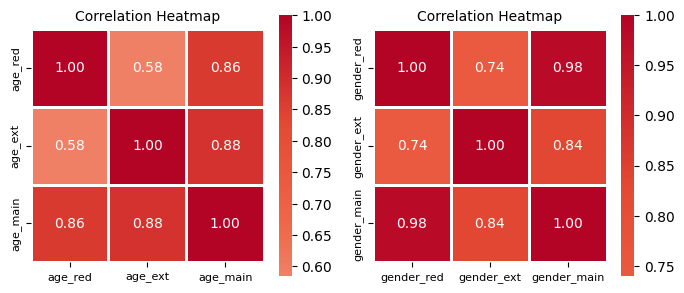

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))

age_min, age_max = age_corr.values.min(), age_corr.values.max()
gender_min, gender_max = gender_corr.values.min(), gender_corr.values.max()

# Maintain same colors between heatmaps
total_min = min(age_min, gender_min)
total_max = max(age_max, gender_max)

cmap = truncate_colormap(red_palette, 0.2, 1.0)

# --------------------------------------------------
# Age heatmap
# --------------------------------------------------
hm_age = sns.heatmap(
    age_corr,
    ax=axes[0],
    cmap=cmap,
    annot=True,
    fmt=".2f",
    square=True,
    linewidths=1,
    linecolor="white",
    vmin=total_min,
    vmax=total_max,
    cbar=True
)

axes[0].set_title("Correlation Heatmap", fontsize=10)
axes[0].tick_params(axis="x", labelsize=8, rotation=0)
axes[0].tick_params(axis="y", labelsize=8, rotation=90)

# Age colorbar: span min→max, ticks only at multiples of 0.05
cbar_age = hm_age.collections[0].colorbar
age_ticks = ticks_multiple_of_5(age_min, age_max)

cbar_age.set_ticks(age_ticks)
cbar_age.set_ticklabels([f"{t:.2f}" for t in age_ticks])
cbar_age.ax.yaxis.set_major_locator(FixedLocator(age_ticks))
cbar_age.ax.set_ylim(age_min, age_max)

# --------------------------------------------------
# Gender heatmap
# --------------------------------------------------
hm_gen = sns.heatmap(
    gender_corr,
    ax=axes[1],
    cmap=cmap,
    annot=True,
    fmt=".2f",
    square=True,
    linewidths=1,
    linecolor="white",
    vmin=total_min,
    vmax=total_max,
    cbar=True
)

axes[1].set_title("Correlation Heatmap", fontsize=10)
axes[1].tick_params(axis="x", labelsize=8, rotation=0)
axes[1].tick_params(axis="y", labelsize=8, rotation=90)

# Gender colorbar: span min→max, ticks only at multiples of 0.05
cbar_gen = hm_gen.collections[0].colorbar
gen_ticks = ticks_multiple_of_5(gender_min, gender_max)

cbar_gen.set_ticks(gen_ticks)
cbar_gen.set_ticklabels([f"{t:.2f}" for t in gen_ticks])
cbar_gen.ax.yaxis.set_major_locator(FixedLocator(gen_ticks))
cbar_gen.ax.set_ylim(gender_min, gender_max)

plt.tight_layout()
plt.show()


**Result interpretation.**  
The pairwise correlation heatmaps show strong and consistently positive associations across all alternative age and gender extraction methods. For age, correlations range from moderate to high (0.58–0.88), while for gender they are uniformly very high (0.74–0.98). This indicates that, although different extraction procedures introduce some variability,particularly for age, the underlying age and gender dimensions remain largely aligned. This confirms that the observed age–gender association is robust.


### Relationship Between Age and Gender

To further characterize the association between age and gender, we estimate a linear regression model with **normalized age** as the dependent variable and **normalized gender** as the independent variable.

The model is estimated using ordinary least squares (OLS). 


In [15]:
y = df["age_norm_main"]
x = df[["gender_norm_main"]]

# gender as independent variable
X = sm.add_constant(x)

model = sm.OLS(y, X)
results = model.fit()

results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          age_norm_main   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                 1.114e+04
Date:                Sun, 21 Dec 2025   Prob (F-statistic):               0.00
Time:                        23:27:37   Log-Likelihood:                 5425.6
No. Observations:                3495   AIC:                        -1.085e+04
Df Residuals:                    3493   BIC:                        -1.083e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0211      0.003     -6.510      0.000      -0.027      -0.015
gender_norm_main     0.7450      0.007    105.565      0.000       0.731       0.759
==============================================================================
Omnibus:                      829.901   Durbin-Watson:                   1.255
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4643.267
Skew:                           1.012   Prob(JB):                         0.00
Kurtosis:                       8.271   Cond. No.                         9.75
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Result interpretation.**  
The OLS regression reveals a strong and highly significant relationship between normalized gender and normalized age. The estimated coefficient on `gender_norm.main` is positive and large (β = 0.745, *p* < 0.001), indicating that categories positioned as more male-coded in the embedding space are systematically associated with higher perceived age. The model explains a substantial share of the variance in age (R² = 0.761), confirming the association observed in the correlation analysis.

Residual diagnostic statistics(JB, Omnibus, Durbin-Watson tests) indicate non-normal residuals, which is expected given the bounded [0,1] of the scores. Overall, the results support the presence of a strong structural alignment between age and gender representations in GPT-2.


### Regression Visualization with Representative Categories

To complement the regression table, we visualize the relationship between normalized gender and normalized age in a scatter plot. Each point corresponds to a social category, positioned by its **gender association score** (x-axis) and **age association score** (y-axis). We overlay the fitted OLS regression line to show the average linear trend.

Following the paper, we additionally highlight a small set of **representative categories** at the low and high ends of the association space and annotate them with leader lines. This helps interpret the direction of the distortion in concrete terms and makes it easier to see how individual categories relate to the overall pattern.


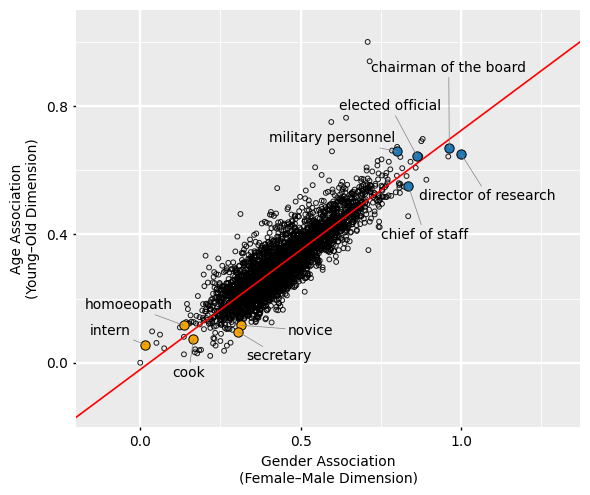

In [16]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.set_facecolor("#EBEBEB")
fig.patch.set_facecolor("white")
ax.set_aspect("equal", adjustable="box")

# -----------------------
# Main scatter plot
# -----------------------
ax.scatter(
    x, y,
    s=12,
    facecolors="none",
    edgecolors="black",
    linewidths=0.7,
    alpha=0.9,
    zorder=2
)

# -----------------------
# Regression line from statsmodels results
# age_norm.main = b0 + b1 * gender_norm.main
# -----------------------
b0 = results.params["const"]
b1 = results.params["gender_norm_main"]

ax.set_ylim(-0.2, 1.1)
x_at_y1 = (1.0 - b0) / b1
ax.set_xlim(-0.2, float(x_at_y1))


xmin, xmax = ax.get_xlim()
xx = np.array([xmin, xmax])
yy = b0 + b1 * xx
ax.plot(xx, yy, color="red", linewidth=1.2, zorder=3)

# ============================================================
# Highlight representative categories
# - low (more female-coded / younger-coded examples)
# - high (more male-coded / older-coded examples)
# ============================================================
low_cats = ["intern", "cook", "secretary", "novice", "homoeopath"]
high_cats = [
    "military personnel", "elected official",
    "chairman of the board", "chief of staff", "director of research"
]

low_df = df[df["social_category"].isin(low_cats)]
high_df = df[df["social_category"].isin(high_cats)]

# Highlight low-end examples (orange)
ax.scatter(
    low_df["gender_norm_main"],
    low_df["age_norm_main"],
    c="#f4a300",
    edgecolors="black",
    linewidths=0.7,
    s=45,
    zorder=4
)

# Highlight high-end examples (blue)
ax.scatter(
    high_df["gender_norm_main"],
    high_df["age_norm_main"],
    c="#1f77b4",
    edgecolors="black",
    linewidths=0.7,
    s=45,
    zorder=4
)


# -----------------------
# Annotation helper:
# label a category with a subtle leader line (no arrow head)
# xy = true point location, xytext = manual label location
# -----------------------
def label_at(cat, x_text, y_text, ha="left"):
    r = df.loc[df["social_category"] == cat].iloc[0]
    ax.annotate(
        cat,
        xy=(r["gender_norm_main"], r["age_norm_main"]),
        xytext=(x_text, y_text),
        textcoords="data",
        fontsize=10,
        color="black",
        ha=ha,
        va="center",
        arrowprops=dict(
            arrowstyle="-",
            color="gray",
            lw=0.5,
            shrinkA=0,
            shrinkB=0
        ),
        zorder=5
    )

# Manual label placements (tuned to avoid overlaps)
label_at("homoeopath",  0.1, 0.18, ha="right")
label_at("intern",     -0.03, 0.10, ha="right")
label_at("cook",        0.1, -0.03, ha="left")

label_at("secretary",   0.33, 0.02, ha="left")
label_at("novice",      0.46, 0.10, ha="left")

label_at("military personnel", 0.40, 0.70, ha="left")
label_at("elected official",   0.62, 0.80, ha="left")
label_at("chairman of the board", 0.72, 0.92, ha="left")

label_at("chief of staff",      0.75, 0.40, ha="left")
label_at("director of research", 0.87, 0.52, ha="left")


ax.set_xlabel("Gender Association\n(Female–Male Dimension)")
ax.set_ylabel("Age Association\n(Young–Old Dimension)")

# -----------------------
# Ticks and Grid
# -----------------------
ax.yaxis.set_major_locator(MultipleLocator(0.4))
ax.yaxis.set_minor_locator(MultipleLocator(0.2))
ax.grid(True, axis="y", which="major", color="white", linewidth=1.0)
ax.grid(True, axis="y", which="minor", color="white", linewidth=0.6)
for yline in (0.0, 0.4, 0.8):
    ax.axhline(yline, color="white", linewidth=1.6, zorder=1)
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))
ax.grid(True, axis="x", which="major", color="white", linewidth=1.0)
ax.grid(True, axis="x", which="minor", color="white", linewidth=0.6)
for xline in (0.0, 0.5, 1.0):
    ax.axvline(xline, color="white", linewidth=1.6, zorder=1)
ax.tick_params(axis="x", which="major", length=2.5, width = 1)
ax.tick_params(axis="x", which="minor", length=0)
ax.tick_params(axis="y", which="major", length=2.5, width = 1)
ax.tick_params(axis="y", which="minor", length=0)

ax.set_axisbelow(True)
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()


**Figure interpretation.**  
The plot makes the strong positive relationship visually explicit: categories that are more male-related tend to be positioned higher on the age dimension (older), while more female-related categories cluster lower (younger). The highlighted examples illustrate this pattern at the extremes and provide intuitive anchors for interpreting the axes.

### Interactive Regression Plot

To enable a more complete inspection of the data, we create an **interactive** version of the regression plot.

In this visualization, each point corresponds to a social category. Hovering over any point reveals the category name and its normalized gender and age association scores.


In [17]:
alt.data_transformers.disable_max_rows()

# -----------------------
# Rename columns to Altair-friendly names (no dots)
# -----------------------
dfp = df

# -----------------------
# Regression parameters (age_norm_main = b0 + b1 * gender_norm_main)
# ----------------------
b0 = float(results.params["const"])
b1 = float(results.params["gender_norm_main"])

# Chart domain: normalized variables are expected in [0,1]
ymin, ymax = 0.0, 1.0
xmin, xmax = 0.0, 1.0

reg_df = pd.DataFrame({
    "x": [xmin, xmax],
    "y": [b0 + b1 * xmin, b0 + b1 * xmax]
})


# ============================================================
# Choose a few representative categories to highlight
# - low_cats: illustrative "more female-coded / younger-coded" examples
# - high_cats: illustrative "more male-coded / older-coded" examples
# ============================================================
low_cats = ["intern", "cook", "secretary", "novice", "homoeopath"]
high_cats = [
    "military personnel", "elected official",
    "chairman of the board", "chief of staff", "director of research"
]

low_df  = dfp[dfp["social_category"].isin(low_cats)]
high_df = dfp[dfp["social_category"].isin(high_cats)]

# Remove highlighted categories from grey points
highlight_cats = set(low_cats) | set(high_cats)
base_df = dfp[~dfp["social_category"].isin(highlight_cats)].copy()

ticks_01 = [round(v, 1) for v in np.arange(0.0, 1.0 + 0.1, 0.1)]

# ============================================================
# Hover interaction
# ============================================================
hover = alt.selection_point(fields=["social_category"], on="mouseover", nearest=True, empty="none")

# ============================================================
# Base layer: all points, faint grey
# - tooltip shows category + coordinates
# ============================================================
base = alt.Chart(base_df).mark_point(
    filled=True,
    size=55,
    color="#cfcece",
    opacity=0.7,
    stroke="#000000",
    strokeWidth=0.25
).encode(
    x=alt.X(
        "gender_norm_main:Q",
        scale=alt.Scale(domain=[0.0, 1.0]),
        axis=alt.Axis(
            title=["Gender Association", "(Female–Male Dimension)"],
            titleFontWeight="bold",
            titleFontSize=13,
            titlePadding=12,
            values=ticks_01,
            format=".1f",
            grid=True
        )
    ),
    y=alt.Y(
        "age_norm_main:Q",
        scale=alt.Scale(domain=[0.0, 1.0]),
        axis=alt.Axis(
            title=["Age Association", "(Young–Old Dimension)"],
            titleFontWeight="bold",
            titleFontSize=13,
            titlePadding=12,
            values=ticks_01,
            format=".1f",
            grid=True
        )
    ),
    tooltip=[
        alt.Tooltip("Social_Category:N", title="social_category"),
        alt.Tooltip("gender_norm_main:Q", title="gender_norm", format=".2f"),
        alt.Tooltip("age_norm_main:Q", title="age_norm", format=".2f"),
    ]
).add_params(hover)



# ============================================================
# Highlight layers: selected "low" and "high" categories
# ============================================================
low_pts = alt.Chart(low_df).mark_point(
    filled=True, size=180,
    color="#DAA520",
    opacity=0.7
).encode(
    x="gender_norm_main:Q",
    y="age_norm_main:Q",
    size=alt.condition(hover, alt.value(260), alt.value(180)),
    opacity=alt.condition(hover, alt.value(1.0), alt.value(0.7)),
    stroke=alt.condition(hover, alt.value("black"), alt.value(None)),
    strokeWidth=alt.value(1),
    tooltip=[
        alt.Tooltip("Social_Category:N", title="Social category"),
        alt.Tooltip("gender_norm_main:Q", title="Gender assoc.", format=".2f"),
        alt.Tooltip("age_norm_main:Q", title="Age assoc.", format=".2f"),
    ]
).add_params(hover)

high_pts = alt.Chart(high_df).mark_point(
    filled=True, size=180,
    color="#1E90FF",
    opacity=0.7
).encode(
    x="gender_norm_main:Q",
    y="age_norm_main:Q",
    size=alt.condition(hover, alt.value(260), alt.value(180)),
    opacity=alt.condition(hover, alt.value(1.0), alt.value(0.7)),
    stroke=alt.condition(hover, alt.value("black"), alt.value(None)),
    strokeWidth=alt.value(1),
    tooltip=[
        alt.Tooltip("Social_Category:N", title="Social category"),
        alt.Tooltip("gender_norm_main:Q", title="Gender assoc.", format=".2f"),
        alt.Tooltip("age_norm_main:Q", title="Age assoc.", format=".2f"),
    ]
).add_params(hover)

# -----------------------
# Regression line layer
# -----------------------
reg_line = alt.Chart(reg_df).mark_line(color="red", strokeWidth=3).encode(x="x:Q", y="y:Q")

# ============================================================
# Final Chart
# ============================================================
chart = alt.layer(
    base, low_pts, high_pts, reg_line
).properties(
    width=620,
    height=520
).configure_view(
    fill="white",
    stroke="#d9d9d9"
).configure_axis(
    gridColor="#e6e6e6",
    gridWidth=1,
    domain=True,
    domainColor="#0a0a0a",
    domainWidth=1,
    tickSize=6,
    tickColor="#000000",
    labelFontSize=12,
    titleFontSize=13
).configure_view(
    fill="white",
    stroke="#d9d9d9"
)



chart


alt.LayerChart(...)

**Comment on additional outliers.**  
A small number of social categories deviate noticeably from the main linear trend, in particular father-in-law, brother-in-law, sister-in-law, mother-in-law.

These categories are outliers because they are strongly associated with older age, probablly because they presuppose marriage and generational hierarchy, while being only weakly gender-coded (brother and father in law are only slightly more male-related that sister and mother in law), since their meaning is defined primarily by kinship relations rather than gendered social or occupational roles. As a result, their age associations are disproportionately high relative to their gender associations, placing them away from the main linear trend.

However sister and mother in law, remain lower on the age scale, than father and brother in law.


The authors do not highlight these outliers because the aim of the analysis is to demonstrate a robust structural relationship between age and gender representations across social categories, rather than to provide an exhaustive interpretation of individual cases. By focusing on a small set of intuitive and recognizable examples, the authors emphasize the general distortion pattern without overloading the reader with labels. Additionally, these outliers do not offer much to the analysis, since they deviate from the main line and not therefore examples, of age and gender distortion.

Additionally, categories such as man of the world or man of the cloth are lexically gendered by construction. Their strong male associations are therefore definitional rather than emergent, and are not informative for assessing age–gender distortion. 


**Additional Highlights**  
While woman is in the femal cluster, it appears more male coded.

## Section 2: Amplification via Google Search

Having established a strong association between age and gender in language model representations, we now examine whether **online image search amplifies this distortion**. To do so, we replicate the experimental design introduced in the referenced study, which compares age estimates across treatment and control conditions.

In the treatment condition, participants searched for occupation-related images using Google Images, uploaded one image, labeled its gender, and then estimated the average age associated with that occupation. In the control condition, participants uploaded images from unrelated categories and estimated the age of a randomly assigned occupation from the same set.

The analysis uses the data in `experiment_control.csv` and `experiment_treatment.csv`. We define the **age distortion measure** as the difference between the age estimated by a participant in the treatment condition and the mean age estimated for the same occupation in the control group. This measure captures how exposure to gendered images shifts perceived age relative to a neutral baseline.


We first read the data.

In [18]:
# load the new data
control = pd.read_csv("experiment_control.csv")
treat   = pd.read_csv("experiment_treatment.csv")

We then compute the mean age estimate for each occupation in the control condition, which serves as the baseline against which treatment-group age estimates are compared.

In [19]:
# Control-category baselines: mean perceived age + mean ideal age
control_agg = (
    control.groupby("category", as_index=False)
    .agg(c_age=("age", "mean"), c_ideal=("ideal_age", "mean"))
)

control_agg.head()


,category,c_age,c_ideal
0,aeronauticalengineer,41.316947,39.494842
1,appliedscientist,40.326404,38.934831
2,artstudent,21.814381,21.648952
3,artteacher,34.208913,32.056304
4,astronaut,38.827849,36.126022


We combine the treatment observations with their baselines.

In [20]:
# Attach control baselines to each treatment observation (matched by category)
treatment_full = treat.merge(control_agg, on="category", how="inner")

treatment_full.head()


,subj,category,age,gender,condition,c_age,c_ideal
0,55a55bd7fdf99b790558627c,artstudent,18.63,Female,Image,21.814381,21.648952
1,55a55bd7fdf99b790558627c,astronaut,30.29,Female,Image,38.827849,36.126022
2,55a55bd7fdf99b790558627c,automotiveengineer,36.06,Male,Image,37.530676,36.423919
3,55a55bd7fdf99b790558627c,chiefexecutiveofficer,46.11,Female,Image,50.171136,46.989886
4,55a55bd7fdf99b790558627c,computerexpert,30.70,Female,Image,35.242952,33.899524


In [21]:
# Keep only clear gender classifications
treatment_full_main = treatment_full[treatment_full["gender"] != "Not Sure"].copy()

To quantify the effect of image search exposure, we compute the **age distortion measure**. For each participant and category, age distortion is defined as the difference between the age estimated in the treatment condition and the mean age estimated for the same category in the control group. Positive values indicate higher perceived age relative to baseline, while negative values indicate lower perceived age.

In [22]:
# Keep only clear gender classifications
treatment_full_main = treatment_full[treatment_full["gender"] != "Not Sure"].copy()
# Age distortion relative to the control mean for the same category
treatment_full_main["age_cent"] = treatment_full_main["age"] - treatment_full_main["c_age"]

treatment_full_main[["category", "gender", "age", "c_age", "age_cent"]].head()


,category,gender,age,c_age,age_cent
0,artstudent,Female,18.63,21.814381,-3.184381
1,astronaut,Female,30.29,38.827849,-8.537849
2,automotiveengineer,Male,36.06,37.530676,-1.470676
3,chiefexecutiveofficer,Female,46.11,50.171136,-4.061136
4,computerexpert,Female,30.70,35.242952,-4.542952


### Distribution of Image-Induced Age Distortions by Gender

We next visualize the distribution of age distortions induced by image search exposure. Using the centered age measure (treatment age minus control-group mean age for the same occupation), we estimate smooth density curves separately for images labeled as **female** and **male**.

Kernel density estimation is used to create a continuous distribution. Vertical reference lines indicate zero distortion (control baseline) as well as the mean distortion for each group.


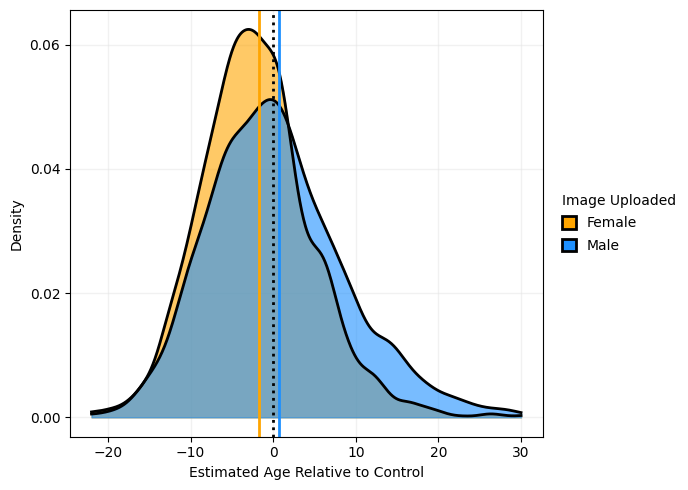

In [23]:
FEMALE_COLOR = "orange"
MALE_COLOR   = "dodgerblue"

# -----------------------
# Extract the two groups (drop missing values)
# age_cent: estimated age relative to control (0 = no distortion)
# -----------------------
female = treatment_full_main.loc[treatment_full_main["gender"]=="Female", "age_cent"].dropna().to_numpy()
male   = treatment_full_main.loc[treatment_full_main["gender"]=="Male",   "age_cent"].dropna().to_numpy()

xmin, xmax = -22, 30
x = np.linspace(xmin, xmax, 700)



# ============================================================
# Bandwidth selection (R-like "nrd0" rule of thumb)
# ===========================================================
def bw_nrd0(data):
    data = np.asarray(data)
    n = data.size
    sd = np.std(data, ddof=1)
    iqr = np.subtract(*np.percentile(data, [75, 25]))
    s = min(sd, iqr / 1.34) if iqr > 0 else sd
    return 0.9 * s * n ** (-1/5)

# KDE wrapper that converts our desired bandwidth into scipy's bw_method factor
def kde(data):
    data = np.asarray(data)
    bw = bw_nrd0(data)
    sd = np.std(data, ddof=1)
    factor = bw / sd if sd > 0 else 1.0
    return gaussian_kde(data, bw_method=factor)

# -----------------------
# Fit KDEs
# -----------------------
kde_f = kde(female)
kde_m = kde(male)

yf = kde_f(x)
ym = kde_m(x)

# ============================================================
# Plot
# ============================================================
fig, ax = plt.subplots(figsize=(7, 5))
ax.set_facecolor("white")

ax.xaxis.set_major_locator(MultipleLocator(10))

ax.yaxis.set_major_locator(MultipleLocator(0.02))

ax.set_axisbelow(True)
ax.grid(
    True,
    which="major",
    color="#E5E5E5",
    linewidth=1,
    alpha=0.5
)



ax.fill_between(x, 0, yf, color=FEMALE_COLOR, alpha=0.6)
ax.fill_between(x, 0, ym, color=MALE_COLOR,   alpha=0.6)

# Outline curves (black) to keep both densities readable
ax.plot(x, yf, color="black", linewidth=2)
ax.plot(x, ym, color="black", linewidth=2)


# -----------------------
# Reference lines:
# ----------------------
ax.axvline(0, color="black", linestyle=":", linewidth=2)
ax.axvline(female.mean(), color=FEMALE_COLOR, linewidth=2)
ax.axvline(male.mean(),   color=MALE_COLOR,   linewidth=2)
pad = 0.05 * (xmax - xmin)
ax.set_xlim(xmin - pad, xmax + pad)
ax.set_xlabel("Estimated Age Relative to Control")
ax.set_ylabel("Density")

# -----------------------
# Legend
# -----------------------
handles = [
    Patch(facecolor=FEMALE_COLOR, edgecolor="black", linewidth=2.0, label="Female"),
    Patch(facecolor=MALE_COLOR,   edgecolor="black", linewidth=2.0, label="Male"),
]

leg = ax.legend(
    handles=handles,
    title="Image Uploaded",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
    handlelength=1.0,
    handleheight=1.0,
    labelspacing=0.6,
    borderpad=0.2
)

# left align legend
leg._legend_box.align = "left"


plt.tight_layout()
plt.show()


**Figure interpretation.**  
The density plot shows a clear separation between the age distortions induced by female- and male-labeled images. The distribution corresponding to female images is shifted to the left of zero, indicating that participants systematically estimate lower ages relative to the control baseline. In contrast, the distribution for male images is shifted to the right, indicating higher estimated ages relative to control.

The vertical reference lines highlight this asymmetry: the mean distortion for female images is negative, while the mean distortion for male images is positive. Although the two distributions overlap, their centers are clearly displaced in opposite directions. This visual pattern suggests that exposure to gendered images does not merely introduce noise, but **systematically amplifies age distortion in a gender-specific manner**, motivating the formal statistical tests that follow. The significance of this needs to be verified by a t-test.


### T-tests Analysis

To evaluate gender differences in perceived age, we conduct a series of t-tests on participants’ age estimates. We first compare age ratings for female versus male images using a two-sample t-test. We then assess treatment effects relative to the control condition by performing one-sample t-tests on age estimates centered by the control mean. All tests are two-sided and reported in years.


We first compare average age estimates for occupations associated with female versus male images.


In [24]:
female_df = treatment_full_main[treatment_full_main["gender"] == "Female"]
male_df   = treatment_full_main[treatment_full_main["gender"] == "Male"]

#  conduct t-test on female vs male images on the treatment set
ttest = stats.ttest_ind(female_df["age"], male_df["age"], equal_var=False)

female_mean = female_df["age"].mean()
male_mean   = male_df["age"].mean()

print(f"Male − Female mean difference: {(male_mean - female_mean):.2f}")
print(
    f"t-test: t = {ttest.statistic:.2f}, "
    f"p = {ttest.pvalue:.2e}"
)


Male − Female mean difference: 5.46
t-test: t = -19.07, p = 5.24e-78


It is shown that participants who uploaded an image of a woman estimated occupations to be **5.46 years younger** on average than those who uploaded an image of a man (t = −19.07, p < 0.001). The test is statistically significant.


Next, we compare age estimates in each treatment condition to the control baseline using one-sample t-tests on control-centered age estimates.


In [25]:
# Split the treatment data by gender
female_cent = female_df["age_cent"].dropna()
male_cent   = male_df["age_cent"].dropna()

# one sample t-tests on female vs control(0) and male vs control(0)
t_f = stats.ttest_1samp(female_cent, popmean=0.0)
t_m = stats.ttest_1samp(male_cent,   popmean=0.0)

print("\nFemale vs control (age_cent vs 0):")
print(f"Mean: {female_cent.mean():.2f}")
print(
    f"t-test: t = {t_f.statistic:.2f}, "
    f"p = {t_f.pvalue:.2e}"
)

print("\nMale vs control (age_cent vs 0):")
print(f"Mean: {male_cent.mean():.2f}")
print(
    f"t-test: t = {t_m.statistic:.2f}, "
    f"p = {t_m.pvalue:.2e}"
)



Female vs control (age_cent vs 0):
Mean: -1.75
t-test: t = -11.32, p = 4.82e-29

Male vs control (age_cent vs 0):
Mean: 0.64
t-test: t = 3.42, p = 6.37e-04


Relative to control, female images reduced age estimates by 1.75 years (t = −11.32), while male images increased estimates by 0.64 years (t = 3.42). Both tests have p < 0.001 and are therefore statistically significant.


**Note.**  
In the paper, p-values are reported as 2.2 × 10<sup>−16</sup> for the male–female and female–control comparisons, whereas our estimates are substantially smaller. This difference arises from R’s default reporting convention, which prints p-values smaller than machine precision as < 2.2 × 10<sup>−16</sup>, while SciPy reports the full numerical value.

### Investigating Amplification with Regression Analysis

To examine whether online image search amplifies age–gender distortion beyond simple mean differences, we estimate a regression model on the **combined treatment and control dataset**. The dependent variable is the participant’s estimated age.

The model includes the following independent variables:
- **condition × gender**, where gender is treated as a categorical variable with Treatment coding and **Male** as the reference level,
- **category**
- **subject**.

This specification allows us to isolate the effect of image exposure and its interaction with gender while holding constant both occupation-specific and participant-specific factors.


For the regression-based amplification analysis, we combine the treatment and control observations into a single dataset. We retain subject identifiers, occupation categories, estimated ages, gender labels, and experimental condition indicators. This unified dataset enables direct comparison across conditions and supports the inclusion of subject- and category-level controls in subsequent regression models.


In [26]:
# keep only relevant columns
control = control[["subj", "category", "age", "gender", "condition"]]
treat   = treat[["subj", "category", "age", "gender", "condition"]]

dt_main = pd.concat([treat, control], axis=0, ignore_index=True)

Before estimating the regression models, we restrict the dataset to observations with a clearly identified gender label and convert all categorical variables to categorical data types.


In [27]:
# Only male and female
dt_main = dt_main[dt_main["gender"].isin(["Male", "Female"])].copy()

dt_main["gender"] = dt_main["gender"].astype("category")
dt_main["condition"] = dt_main["condition"].astype("category")
dt_main["category"] = dt_main["category"].astype("category")
dt_main["subj"] = dt_main["subj"].astype("category")

We estimate a linear regression model on the combined dataset with **age** as the dependent variable. The specification includes an interaction between experimental **condition** and **gender**, where gender is treated as a categorical variable using Treatment coding with **Male** as the reference level.

In addition, we include fixed effects for **occupation category** and **subject**, allowing us to control for systematic differences across occupations and individual respondents. This model directly tests whether exposure to gendered images amplifies age distortion while holding constant both occupation and subject.


In [28]:
# age ~ condition × gender + category FE + subject FE
model = smf.ols(
    formula="""
        age ~ condition * C(gender, Treatment(reference="Male"))
              + C(category)
              + C(subj)
    """,
    data=dt_main
).fit()

summary_html = model.summary().as_html()

display(HTML(f"""
<div style="
    max-height: 400px;
    overflow-y: auto;
    border: 1px solid #ccc;
    padding: 10px;
    background-color: black;
">
{summary_html}
</div>
"""))

**Result interpretation.**  
The regression confirms strong amplification effects after jointly accounting for condition, gender, occupation, and subject. Relative to the control condition, exposure to Google Image search is associated with a significant downward shift in age estimates (β ≈ −4.78, *p* = 0.001). In addition, gender has a substantial independent effect: images labeled as female are associated with significantly lower age estimates compared to male images (β ≈ −2.19, *p* < 0.001), holding condition constant.

The intercept (44) represents the predicted perceived age for a male image in the control condition, for the reference category and reference subject.

The inclusion of the condition–gender interaction and fixed effects for category and subject ensures that these effects are not driven by occupational composition or individual response tendencies. The model explains a good portion of the variance in age estimates (R² ≈ 0.59), indicating that image exposure, gender labeling, and structural controls together capture much of the systematic variation in perceived age.

Overall, these results provide regression-based evidence that online image search **amplifies age–gender distortion**, reinforcing the distributional and t-test findings presented earlier.


#### Regression With Occupation and Subject Effects Only

We estimate a regression model with **age** as the dependent variable and only **occupation category** and **subject** fixed effects as independent variables. This specification excludes experimental condition and gender, capturing the age estimates that would be expected solely based on occupational differences and individual respondent tendencies.

The fitted model is then used to generate predicted ages, which serve as a reference point for analyzing how treatment and gender systematically shift perceptions away from this baseline.


In [29]:
baseline_model = smf.ols(
    formula="age ~ C(category) + C(subj)",
    data=dt_main
).fit()

baseline_summary_html = baseline_model.summary().as_html()

display(HTML(f"""
<div style="
    max-height: 400px;
    overflow-y: auto;
    border: 1px solid #ccc;
    padding: 10px;
    background-color: black;
">
{baseline_summary_html}
</div>
"""))


**Result interpretation.**

The regression explains a good share of the variation in perceived age (R² = 0.576), showing that age judgments are strongly structured by both occupation and subject fixed effects. Relative to the reference category, some occupations are perceived as much younger—such as art students (−17.3 years, p < 0.001) and art teachers (−3.7 years, p < 0.001), while others are perceived as older, including chief executive officers (+10.1 years, p < 0.001) and astrophysicists (+5.3 years, p < 0.001). The intercept of 44.2 reflects the baseline perceived age for the reference occupation. Because this model includes only occupation fixed effects and excludes condition and gender, it serves as a baseline against which treatment- and gender-related age distortions are examined in subsequent analyses.


Using the regression model, we compute predicted age estimates for each observation in the combined dataset. The **predicted age** represents the age expected based solely on occupation and subject effects, while the **residual** captures the deviation from this baseline. These residuals isolate the remaining variation in age estimates that may be attributable to experimental condition and gender, and they are used in the subsequent visual analysis.


In [30]:
dt_main = dt_main.copy()

# We then use the model to predict ages for the combined dataset
dt_main["age_pred"] = baseline_model.predict(dt_main)

# capture residuals
dt_main["residual"] = dt_main["age"] - dt_main["age_pred"]

dt_main[["age", "age_pred", "residual"]].head()


,age,age_pred,residual
0,18.63,21.061530,-2.431530
1,30.29,39.019255,-8.729255
2,36.06,35.595814,0.464186
3,46.11,48.485434,-2.375434
4,30.70,32.711883,-2.011883


To facilitate comparison across experimental groups, we summarize the baseline-model predictions by **condition** and **gender**. For each group, we compute the mean predicted age along with its standard error. These aggregated predictions provide a clear view of how expected age estimates—based only on occupation and subject effects, differ across conditions and genders, and serve as the basis for the grouped prediction plot that follows.


In [31]:
pred_summary = (
    dt_main
    .groupby(["condition", "gender"])
    .agg(
        pred_mean=("age_pred", "mean"),
        pred_se=("age_pred", lambda x: x.std() / (len(x) ** 0.5)) # Standard error of the mean predicted age (SD / sqrt(n))
    )
    .reset_index()
)

pred_summary


C:\Users\Admin\AppData\Local\Temp\ipykernel_14132\3467369914.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["condition", "gender"])


,condition,gender,pred_mean,pred_se
0,Control,Female,34.286134,0.177657
1,Control,Male,39.832903,0.162167
2,Image,Female,35.024128,0.148557
3,Image,Male,38.599109,0.153704


##### Group-Level Summary of Residual Age Distortions

To directly assess amplification effects beyond baseline expectations, we summarize the **residuals** from the baseline regression by experimental condition and gender. The residual represents the deviation of an individual age estimate from what would be expected based solely on occupation and subject effects.

For each condition–gender group, we compute the mean residual and its standard error. These summaries form the basis for the residual-based visualization that follows and allow us to isolate how image exposure and gender jointly shift age perceptions relative to the baseline model.


In [32]:
resid_summary = (
    dt_main
    .groupby(["condition", "gender"])
    .agg(
        resid_mean=("residual", "mean"),
        resid_se=("residual", lambda x: x.std() / (len(x) ** 0.5)) # Standard error of the mean predicted age (SD / sqrt(n))
    )
    .reset_index()
)

resid_summary


C:\Users\Admin\AppData\Local\Temp\ipykernel_14132\3390261783.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["condition", "gender"])


,condition,gender,resid_mean,resid_se
0,Control,Female,-0.368949,0.149314
1,Control,Male,0.365164,0.154462
2,Image,Female,-0.876526,0.123249
3,Image,Male,1.013092,0.147402


##### Baseline Predictions vs Residual Distortions

We jointly visualize the results of the baseline and residual analyses using a two-panel figure.  
The **left panel** shows group-level predicted ages from the baseline model (occupation and subject effects only), while the **right panel** shows the corresponding mean residuals by experimental condition and gender.

Presenting these plots side by side highlights the contrast between baseline expectations and the additional distortion introduced by image exposure.


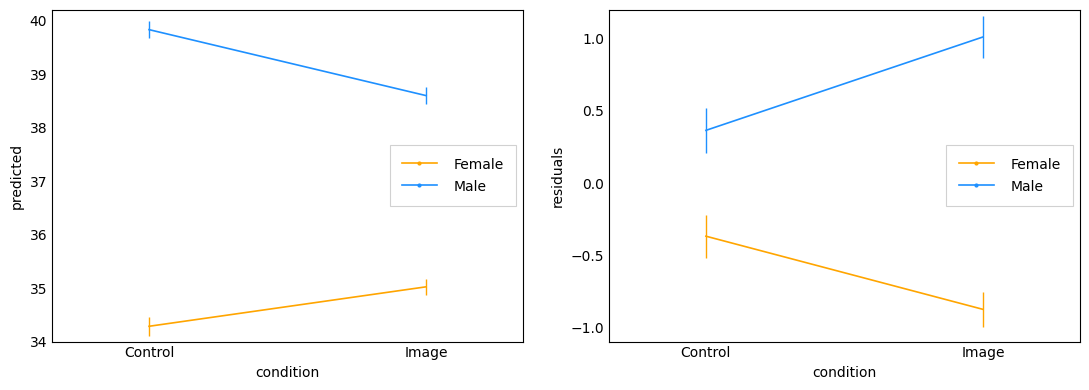

In [33]:
order = ["Control", "Image"]

handles = [
    Line2D(
        [0], [0],
        color="orange",
        linewidth=1.2,
        marker="o",
        markersize=2,
        markerfacecolor="orange",
        markeredgecolor="orange",
        label="Female"
    ),
    Line2D(
        [0], [0],
        color="dodgerblue",
        linewidth=1.2,
        marker="o",
        markersize=2,
        markerfacecolor="dodgerblue",
        markeredgecolor="dodgerblue",
        label="Male"
    ),
]
fig, (ax1, ax2) = plt.subplots(
    1, 2,
    figsize=(11, 4),
    sharex=False
)
x_pos = {"Control": 0.0, "Image": 0.6}


# ------------------------------------------------------------
# Panel 1: Predicted age by condition and gender
# ------------------------------------------------------------
for gender, color in [("Female", "orange"), ("Male", "dodgerblue")]:
    # Subset predictions by gender and set order
    subset = (pred_summary[pred_summary["gender"] == gender]
              .set_index("condition")
              .loc[order]
              .reset_index())
    # Plot mean predicted age with standard error bars
    ax1.errorbar(
        subset["condition"],
        subset["pred_mean"],
        yerr=subset["pred_se"],
        color=color,
        linestyle="-",
        linewidth=1.2,
        marker=None,
        capsize=0,
        elinewidth=1.0
    )

ax1.set_xlabel("condition")
ax1.set_ylabel("predicted")
ax1.set_ylim(34, 40.2)
ax1.margins(x=0.35)
leg1 = ax1.legend(
    handles=handles,
    loc="center right",
    frameon=True,
    fancybox=False,
    handlelength=2.5,
    handleheight=1.0,
    labelspacing=0.6,
    handletextpad=1.2,
    borderpad=0.9
)
leg1.get_frame().set_linewidth(0.8)
leg1.get_frame().set_alpha(0.9)

# ------------------------------------------------------------
# Panel 2: Residualized age distortions by condition and gender
# ------------------------------------------------------------
for gender, color in [("Female", "orange"), ("Male", "dodgerblue")]:
    # Subset residual summaries by gender and condition
    subset = (resid_summary[resid_summary["gender"] == gender]
              .set_index("condition")
              .loc[order]
              .reset_index())

    ax2.errorbar(
        subset["condition"],
        subset["resid_mean"],
        yerr=subset["resid_se"],
        color=color,
        linestyle="-",
        linewidth=1.2,
        marker=None,
        capsize=0,
        elinewidth=1.0
    )

ax2.set_xlabel("condition")
ax2.set_ylabel("residuals")
ax2.set_ylim(-1.1, 1.2)
ax2.margins(x=0.35)
leg2 = ax2.legend(
    handles=handles,
    loc="center right",
    frameon=True,
    fancybox=False,
    handlelength=2.5,
    handleheight=1.0,
    labelspacing=0.6,
    handletextpad=1.2,
    borderpad=0.9
)
leg2.get_frame().set_linewidth(0.8)
leg2.get_frame().set_alpha(0.9)

for ax in (ax1, ax2):
    ax.tick_params(axis="both", which="both", length=0)

plt.tight_layout(w_pad=2.0)
plt.show()


**Figure interpretation.**  
The left panel confirms that baseline predicted ages are broadly stable across experimental conditions for both genders. This is expected, as the baseline model excludes condition and gender by construction and therefore provides a neutral reference based on occupation and subject effects alone.

In contrast, the right panel reveals an amplification effect. In the image-search condition, residuals diverge sharply by gender: images labeled as female are associated with negative residuals (younger-than-expected age estimates), while images labeled as male are associated with positive residuals (older-than-expected age estimates). Residuals in the control condition remain close to zero for both genders.

Together, these panels demonstrate that the observed age–gender distortion does not arise from baseline occupational expectations, but is **introduced and amplified by exposure to gendered images**, providing strong evidence in support of the amplification hypothesis.


### ANOVA Analysis of Age–Gender Distortion

As a final robustness check, we analyze the amplification effect using **ANOVA models** with **age** as the dependent variable. ANOVA allows us to assess the contribution of experimental condition, gender, and their interaction.

We estimate two models:

1. A baseline ANOVA with **condition × gender** as independent variables, both using **Sum encoding**, which tests for overall main and interaction effects averaged across groups.

2. An extended ANOVA that includes **condition × gender** (Sum encoded) as well as **occupation category** and **subject** effects.

#### ANOVA I: Condition × Gender (Sum Encoding)

We first estimate an ANOVA model with **age** as the dependent variable and **condition × gender** as independent variables, both specified with **Sum encoding**. This encoding tests for population-level main effects and interactions by comparing each level to the overall mean rather than to a single reference category.

This model evaluates whether experimental condition, gender, and their interaction jointly explain variation in age estimates without controlling for occupation- or subject-level differences.


In [34]:
anova1 = smf.ols(
    formula="""
        age ~ C(condition, Sum) * C(gender, Sum)
    """,
    data=dt_main
).fit()

# Use Type II to test main effects controlling for the other main effect
anova1_table = anova_lm(anova1, typ=2)
anova1_table


,sum_sq,df,F,PR(>F)
"C(condition, Sum)",57.586138,1.0,0.607880,4.356088e-01
"C(gender, Sum)",71856.913990,1.0,758.522619,5.017108e-160
"C(condition, Sum):C(gender, Sum)",347.367889,1.0,3.666820,5.553946e-02
Residual,806175.481608,8510.0,NaN,NaN


**Result interpretation.**  
The ANOVA reveals a very strong main effect of gender on perceived age (F = 758.5, p < 10⁻¹⁵⁹), indicating that male and female images differ substantially in age estimates when averaged across conditions. In contrast, there is no significant main effect of condition (F = 0.61, p = 0.44), suggesting that image exposure does not shift perceived age uniformly across genders. Importantly, the condition × gender interaction is marginally significant (F = 3.67, p = 0.055), providing suggestive evidence that the effect of image exposure on perceived age differs by gender.

Together, these results indicate that while gender strongly structures age perceptions overall, the amplification effect emerges specifically through the interaction between gender and experimental condition rather than through a uniform treatment effect.

#### ANOVA II: Condition × Gender with Occupation and Subject Controls

We now estimate a second ANOVA model that extends the previous specification by including **occupation category** and **subject** effects, while retaining **condition × gender** with Sum encoding.

In [35]:
anova2 = smf.ols(
    formula="""
        age ~ C(condition, Sum) * C(gender, Sum)
              + C(category)
              + C(subj)
    """,
    data=dt_main
).fit()

anova2_table = anova_lm(anova2, typ=2)
anova2_table


,sum_sq,df,F,PR(>F)
"C(condition, Sum)",620.352248,1.0,13.649851,2.217273e-04
"C(gender, Sum)",8055.025507,1.0,177.237846,5.166031e-40
C(category),230669.638586,53.0,95.764404,0.000000e+00
C(subj),456023.489314,453.0,22.150246,0.000000e+00
"C(condition, Sum):C(gender, Sum)",329.073698,1.0,7.240736,7.141576e-03
Residual,363807.622227,8005.0,NaN,NaN


**Result interpretation.**  
When occupation and subject effects are included, the ANOVA reveals a significant main effect of condition (F = 13.65, p = 2.2 × 10⁻⁴), indicating that image exposure affects perceived age once structural differences across occupations and respondents are accounted for. The main effect of gender remains strong (F = 177.24, p < 10⁻³⁹), confirming substantial baseline differences in age perceptions between male- and female-labeled images. As expected, occupation (F = 95.76, p < 10⁻¹⁶) and subject (F = 22.15, p < 10⁻¹⁶) explain large portions of variance, reflecting systematic differences across roles and consistent rater tendencies.

Crucially, the condition × gender interaction is now clearly significant (F = 7.24, p = 0.007), demonstrating that exposure to images affects perceived age differently for male and female images even after controlling for occupation and subject differencies.

Taken together with the previous ANOVA, these results show that age–gender distortion is not driven only by occupational differences, but arises from the joint effect of gender and image exposure, consistent with the amplification pattern observed throughout the analysis.
